# 크롤링

### 필요 라이브러리 임포트

In [13]:
import time
import numpy as np
import pandas as pd
from urllib.request import Request, urlopen
from fake_useragent import UserAgent
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import re
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import folium
import warnings
warnings.simplefilter(action="ignore",category=FutureWarning)

chrome_options = webdriver.ChromeOptions()

### selenium으로 url get

In [ ]:
url = "https://www.saramin.co.kr/zf_user/"
driver = webdriver.Chrome(service = Service('data_analysis/Driver/chromedriver'),options=chrome_options)
driver.get(url)

In [ ]:
# driver = webdriver.Chrome(executable_path="C:/Users/leeyj/LYJPython/Driver/chromedriver.exe")

### 사람인 사이트에서 로봇 검색

In [ ]:
driver.find_element(By.ID, "btn_search" ).click()

In [ ]:
search = driver.find_element(By.ID, "ipt_keyword_recruit")

In [ ]:
search.send_keys("로봇")

In [ ]:
search.send_keys(Keys.ENTER)

In [ ]:
# 채용정보 더보기 버튼 클릭
driver.find_element(By.CSS_SELECTOR,"#recruit_info_list > div.content_bottom > div > a").click()

In [ ]:
# 1페이지로 이동
driver.find_element(By.XPATH,'''//*[@id="recruit_info_list"]/div[2]/div/a[1]''').click()

### 데이터 저장 준비

In [ ]:
name_list = []    # 회사명
url_list = []    # 공고 URL
title_list = []    # 공고 제목
region_list = []    # 근무지
exp_list = []    # 경력 
degree_list = []    # 학력
position_list = []    # 고용 형태
salary_list = []    # 연봉
address_list = []    # 상세 주소
welfare_list = []    # 사내 복지 
statistics_list = []    # 지원자 통계
comInfo_list = []    # 기업 정보
detail_list = []    # 공고 내 html 세부정보
tag_list = []    # 태그

### 데이터 모으기
데이터를 모으는 함수 설정

In [ ]:
def find_info():
    # 페이지 내 모든 공고문들이 들어있는 contents 변수 설정
    contents = driver.find_element(By.CLASS_NAME,"content").find_elements(By.CLASS_NAME,"item_recruit")

    for i in range(len(contents)):    # 공고들의 갯수만큼 반복
        items = contents[i].find_element(By.CLASS_NAME,"job_condition").find_elements(By.TAG_NAME,"span")
        if len(items) == 3:
                name_list.append(contents[i].find_element(By.CLASS_NAME,"corp_name").text)    # 회사명
                url_list.append(contents[i].find_element(By.CLASS_NAME,"job_tit").find_element(By.TAG_NAME,'a').get_attribute("href")) # 공고 URL
                title_list.append(contents[i].find_element(By.CLASS_NAME,"job_tit").text)    # 공고 제목
                region_list.append(items[0].text)    # 근무지
                exp_list.append(items[1].text)    # 경력
                degree_list.append(items[2].text)    # 학력
                position_list.append("")    # 고용 형태
                salary_list.append("")    # 연봉

        elif len(items) == 4:
                name_list.append(contents[i].find_element(By.CLASS_NAME,"corp_name").text)    
                url_list.append(contents[i].find_element(By.CLASS_NAME,"job_tit").find_element(By.TAG_NAME,'a').get_attribute("href")) 
                title_list.append(contents[i].find_element(By.CLASS_NAME,"job_tit").text)    
                region_list.append(items[0].text)
                exp_list.append(items[1].text)
                degree_list.append(items[2].text)
                position_list.append(items[3].text)
                salary_list.append("")

        elif len(items) == 5:
                name_list.append(contents[i].find_element(By.CLASS_NAME,"corp_name").text)    
                url_list.append(contents[i].find_element(By.CLASS_NAME,"job_tit").find_element(By.TAG_NAME,'a').get_attribute("href")) 
                title_list.append(contents[i].find_element(By.CLASS_NAME,"job_tit").text)    
                region_list.append(items[0].text)
                exp_list.append(items[1].text)
                degree_list.append(items[2].text)
                position_list.append(items[3].text)
                salary_list.append(items[4].text)

        ### ---------- 공고클릭시 나오는 ------- ###
        ### ---------- 세부정보 저장 ---------- ###
        contents[i].find_element(By.TAG_NAME,"a").click()    
        driver.implicitly_wait(2)
        second_tab = driver.window_handles[1]   
        driver.switch_to.window(window_name=second_tab)    # 드라이버 포커스를 새 탭(페이지)으로 이동
        # 상세 주소
        try:  
            address_list.append(driver.find_element(By.CLASS_NAME,"address").text)    
        except:
            address_list.append("")
        # 사내 복지
        try:
            # 복리후생이 공고에 포함되있을 때 복지 더보기가 클릭 가능하다면 클릭하여 크롤링
            if driver.find_element(By.CLASS_NAME,"jv_cont.jv_benefit").find_element(By.CLASS_NAME,"jv_title").text == "복리후생":
                if driver.find_element(By.CLASS_NAME,"jv_cont.jv_benefit").find_element(By.CLASS_NAME,"btn_more_cont").click():
                     welfare_list.append(driver.find_element(By.CLASS_NAME,"jv_cont.jv_benefit").find_element(By.CLASS_NAME,"details").text) 
        except:
            pass
        try:
             # 복리후생이 공고에 포함되있을 때 복지 더보기가 없다면 그냥 크롤링
             if driver.find_element(By.CLASS_NAME,"jv_cont.jv_benefit").find_element(By.CLASS_NAME,"jv_title").text == "복리후생":
                  welfare_list.append(driver.find_element(By.CLASS_NAME,"jv_cont.jv_benefit").find_element(By.CLASS_NAME,"details").text)
        except:
             # 위의 도 조건에 부합하므로 빈 문자열을 사내 복지 리스트에 저장
             welfare_list.append("")
        # 지원자 통계
        ###---------- 지원자 통계를 보기위해 로그인 필요 ---------- ###
        try:
            driver.find_element(By.CLASS_NAME,"jv_cont.jv_statics").find_element(By.CLASS_NAME,"btn_more_cont").click() 
            statistics_list.append(driver.find_element(By.CLASS_NAME,"jv_cont.jv_statics.expand").find_element(By.CLASS_NAME,"details").text)
        except:
            statistics_list.append("")
        # 기업 정보
        try:
            comInfo_list.append(driver.find_element(By.CLASS_NAME,"jv_cont.jv_company").find_element(By.CLASS_NAME,"info").text) 
        except:
            comInfo_list.append("")
        # 태그
        try:
            tmp = []
            driver.find_element(By.CLASS_NAME,"jv_cont.jv_footer").find_element(By.CLASS_NAME,"tags").find_element(By.TAG_NAME,"button").click()
            tags = driver.find_element(By.CLASS_NAME,"jv_cont.jv_footer").find_element(By.CLASS_NAME,"tags.on").find_elements(By.TAG_NAME,"li")
            for i in range(len(tags)):
                tmp.append(tags[i].text)
            tag_list.append(tmp)
        except:
            tmp = []
            tags = driver.find_element(By.CLASS_NAME,"jv_cont.jv_footer").find_element(By.CLASS_NAME,"tags").find_elements(By.TAG_NAME,"li")
            for i in range(len(tags)):
                tmp.append(tags[i].text)
            tag_list.append(tmp)

        # 채용 공고 html 이동
        try:
            # 공고 html로 드라이버 포커스를 이동
            driver.switch_to.frame(driver.find_element(By.NAME,'iframe_content_0'))
            if len(driver.find_element(By.CLASS_NAME,"user_content").text )>=1 == True:
                print("텍스트 공고")
                detail_list.append(driver.find_element(By.CLASS_NAME,"user_content").text)
            else:
                print("사진 공고")
                detail_list.append("사진")
        except:
            print("크롤링 불가")    # 반복 실행 불가를 일으키는 오류는 pass
            detail_list.append("")
            
        driver.close()
        first_tab = driver.window_handles[0]
        driver.switch_to.window(window_name=first_tab)

### 1~10페이지 저장

In [ ]:
for k in range(len(driver.find_element(By.CLASS_NAME,"pagination").find_elements(By.TAG_NAME,"span"))):
    find_info()
    if k == len(driver.find_element(By.CLASS_NAME,"pagination").find_elements(By.TAG_NAME,"span")):
        driver.find_element(By.CSS_SELECTOR,"#recruit_info_list > div.content_bottom > div > a.btnNext.page_move.track_event").click()
    j = k+1    
    cnt_str = '''//*[@id="recruit_info_list"]/div[2]/div/a[''' + str(j) + "]"
    driver.find_element(By.XPATH,cnt_str).click()
    time.sleep(0.5)

### 11페이지 후부터 10 페이지 단위로 크롤링(11~20)

In [ ]:
# for k in range(len(driver.find_element(By.CLASS_NAME,"pagination").find_elements(By.TAG_NAME,"span"))):
#     find_info()
#     if k == len(driver.find_element(By.CLASS_NAME,"pagination").find_elements(By.TAG_NAME,"span")):
#         driver.find_element(By.CSS_SELECTOR,"#recruit_info_list > div.content_bottom > div > a.btnNext.page_move.track_event").click()
#         break
#     j = k+2    
#     cnt_str = '''//*[@id="recruit_info_list"]/div[2]/div/a[''' + str(j) + "]"
#     driver.find_element(By.XPATH,cnt_str).click()
#     time.sleep(0.5)

### 11페이지부터 페이지 마지막까지 저장

In [ ]:
while True:
    # 다음 버튼을 계속 클릭할 수 있는 경우 무한 반복하며 크롤링
    # 다음 반복 여부를 flag에 저장
    # 다음 버튼이 존재한다면 for문을 돌며 1~10페이지등의 반복을 수행
    flag = len(driver.find_element(By.CSS_SELECTOR,"#recruit_info_list > div.content_bottom > div > a.btnNext.page_move.track_event").text)
    if flag>=0:
        for k in range(len(driver.find_element(By.CLASS_NAME,"pagination").find_elements(By.TAG_NAME,"span"))):
            find_info()    # 한 페이지 내 크롤링
            if k == len(driver.find_element(By.CLASS_NAME,"pagination").find_elements(By.TAG_NAME,"span")):
                # 페이지의 끝에 도달할 경우    
                # 다음 버튼을 클릭후 탈출하여 다시 flag를 검사
                driver.find_element(By.CSS_SELECTOR,"#recruit_info_list > div.content_bottom > div > a.btnNext.page_move.track_event").click()
                break
            j = k+2    
            cnt_str = '''//*[@id="recruit_info_list"]/div[2]/div/a[''' + str(j) + "]"
            driver.find_element(By.XPATH,cnt_str).click()
            time.sleep(0.5)
    else:
        break    # 다음 버튼이 없으면 반복문 탈출

#### 2차원 리스트인 tag_list를 1차원 형태로 변환

In [ ]:
# 2차원 리스트인 tag_list를 1차원 형태로
# for i in range(len(detail_list)):
#     detail_list[i] = detail_list[i].strip()
for i in range(len(tag_list)):
    tag_list[i] = ','.join(tag_list[i])

### 데이터프레임으로 만든 후 저장

In [ ]:
saramin_df = pd.DataFrame({"회사명":name_list, "공고 제목":title_list, "URL":url_list, "근무지":region_list, "경력":exp_list,\
    "학위":degree_list, "유형":position_list, "사내복지":welfare_list, "상세 주소":address_list, "기업 정보":comInfo_list, "지원자 통계":statistics_list, "태그":tag_list, "세부정보":detail_list})
saramin_df.to_excel("../../data/saramin_df.xlsx",engine="xlsxwriter")
saramin_df.to_csv("../../data/saramin_df.csv",sep=",",encoding="utf-8")

In [ ]:
driver.close()

### 수집된 데이터 합치기

In [ ]:
sdf_1 = pd.read_csv("../eda_venv/data/saramin_df_1to10.csv",encoding="utf-8")
sdf_2 = pd.read_csv("../eda_venv/data/saramin_df_11to20.csv",encoding="utf-8")
sdf_3 = pd.read_csv("../eda_venv/data/saramin_df_21to30.csv",encoding="utf-8")
sdf_4 = pd.read_csv("../eda_venv/data/saramin_df_31to40_detail_update.csv",encoding="utf-8")
sdf_total = pd.concat([sdf_1,sdf_2,sdf_3,sdf_4],axis=0)
sdf_total.to_csv("../eda_venv/data/saramin_df.csv",encoding="utf-8")

In [ ]:
saramin_df = pd.read_csv("../eda_venv/data/saramin_df.csv",encoding="utf-8")

In [15]:
saramin_df = pd.read_excel("../data/saramin_df.xlsx",engine="openpyxl")

### ROS, 자율주행, 기구설계, ML/DL, 임베디드, 제어분야 공고 수 확인

In [ ]:
saramin_df["ML/DL"] = np.nan
saramin_df["로봇 설계 및 제작"] = np.nan
saramin_df["ROS"] = np.nan
saramin_df["임베디드"] = np.nan
saramin_df["주율주행"] = np.nan
saramin_df["제어"] = np.nan

saramin_df["직무"].replace(np.nan,"",inplace=True)
saramin_df["세부정보"].replace(np.nan,"",inplace=True)
saramin_df["세부정보"].replace(np.nan,"",inplace=True)
saramin_df["ML/DL"].replace(np.nan,0,inplace=True)
saramin_df["로봇 설계 및 제작"].replace(np.nan,0,inplace=True)
saramin_df["ROS"].replace(np.nan,0,inplace=True)
saramin_df["임베디드"].replace(np.nan,0,inplace=True)
saramin_df["자율주행"].replace(np.nan,0,inplace=True)
saramin_df["제어"].replace(np.nan,0,inplace=True)

### 공고에서 특정단어가 포함된 공고를 카운트하기위해 1,0의 숫자를 부여한 열을 생성
#### ROS관련 공고 검색

In [ ]:
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("ros"),["ROS"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("robot operating"),["ROS"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("robot operation"),["ROS"]] = 1
saramin_df.loc[saramin_df["세부정보"].replace(" ","").str.contains("로봇운영"),["ROS"]] = 1

#### 자율주행관련 공고 검색

In [ ]:
saramin_df.loc[saramin_df["세부정보"].replace(" ","").str.contains("자율주행"),["자율주행"]] = 1
saramin_df.loc[saramin_df["세부정보"].replace(" ","").str.contains("경로생성"),["자율주행"]] = 1
saramin_df.loc[saramin_df["세부정보"].replace(" ","").str.contains("장애물회피"),["자율주행"]] = 1
saramin_df.loc[saramin_df["세부정보"].replace(" ","").str.contains("사물인식"),["자율주행"]] = 1
saramin_df.loc[saramin_df["세부정보"].replace(" ","").str.contains("물체인식"),["자율주행"]] = 1
saramin_df.loc[saramin_df["세부정보"].replace(" ","").str.contains("객체인식"),["자율주행"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("slam"),["자율주행"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("path planning"),["자율주행"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("obstacle avoidance"),["자율주행"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("lidar"),["자율주행"]] = 1

#### 로봇 설계 및 제작 관련 공고 검색

In [ ]:
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("cad"),["로봇 설계 및 제작"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("cae"),["로봇 설계 및 제작"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("nx"),["로봇 설계 및 제작"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("solidwrorks"),["로봇 설계 및 제작"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("catia"),["로봇 설계 및 제작"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("inventor"),["로봇 설계 및 제작"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.contains("캐드"),["로봇 설계 및 제작"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.contains("솔리드웍스"),["로봇 설계 및 제작"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.contains("카티아"),["로봇 설계 및 제작"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.contains("인벤터"),["로봇 설계 및 제작"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.contains("동역학"),["로봇 설계 및 제작"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.contains("기구학"),["로봇 설계 및 제작"]] = 1
saramin_df.loc[saramin_df["세부정보"].replace(" ","").str.contains("구조해석"),["로봇 설계 및 제작"]] = 1

#### 머신러닝/딥러닝 관련 공고 검색

In [ ]:
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("machine learning"),["ML/DL"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("deep learning"),["ML/DL"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("ml"),["ML/DL"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("dl"),["ML/DL"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("ai"),["ML/DL"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.lower().str.contains("a/i"),["ML/DL"]] = 1
saramin_df.loc[saramin_df["세부정보"].replace(" ","").str.contains("머신러닝"),["ML/DL"]] = 1
saramin_df.loc[saramin_df["세부정보"].replace(" ","").str.contains("기계학습"),["ML/DL"]] = 1
saramin_df.loc[saramin_df["세부정보"].replace(" ","").str.contains("딥러닝"),["ML/DL"]] = 1
saramin_df.loc[saramin_df["세부정보"].replace(" ","").str.contains("강화학습"),["ML/DL"]] = 1
saramin_df.loc[saramin_df["세부정보"].replace(" ","").str.contains("인공지능"),["ML/DL"]] = 1

#### 제어/자동화 관련 공고 검색

In [ ]:
saramin_df.loc[saramin_df["세부정보"].str.contains("자동화"),["제어"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.contains("제어"),["제어"]] = 1
saramin_df.loc[saramin_df["세부정보"].str.contains("시운전"),["제어"]] = 0    # 시운전 공고는 제외

#### 데이터 분석 과정을 위해 태그별로 1을 각기 다르게 만들었던 데이터프레임을 생성

In [16]:
df_auto = saramin_df[saramin_df['자율주행']==1]
df_ml = saramin_df[saramin_df['ML/DL']==1]
df_ros = saramin_df[saramin_df['ROS']==1]
df_dsg = saramin_df[saramin_df['로봇 설계 및 제작']==1]
df_emb = saramin_df[saramin_df['임베디드']==1]
df_ctr = saramin_df[saramin_df['제어']==1]

In [17]:
# 기존 데이터프레임에서 새 데이터프레임을 만들었으므로
# 새 데이터프레임에 인덱스를 부여
df_auto.reset_index(inplace=True)
df_ml.reset_index(inplace=True)
df_ros.reset_index(inplace=True)
df_dsg.reset_index(inplace=True)
df_emb.reset_index(inplace=True)
df_ctr.reset_index(inplace=True)

In [18]:
del df_auto['index']
del df_ml['index']
del df_ros['index']
del df_dsg['index']
del df_emb['index']
del df_ctr['index']

### 단어 빈도 측정
##### 특정 단어가 얼마나 반복되는지를 알아보기 위해 필요한 라이브러리 Import

In [ ]:
from konlpy.tag import Okt
from collections import Counter
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

##### 특수문자를 전부 제거
##### 특수문자를 매치 후 " "로 변경, 대소문자 통일

In [ ]:

compile = re.compile("[-_=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]")
for i in range(len(df_auto)):
    
    tmp = compile.sub(" ",df_auto["직무"][i])
    df_auto["직무"][i] = tmp.lower()

##### 어근 동일화, 토큰화, 불용어 제거를 위해 영어로만 구성된 리스트를 생성

In [ ]:
engLst = []
compile = re.compile("[가-힣ㄱ-하-ㅣ0-9]")
for i in range(len(df_auto)):
    tmp = compile.sub("",df_auto["직무"][i])
    engLst.append(tmp.strip())

##### 영문에서 어근 동일화,토큰화를,불용어제거 수행
- PorterStemmer로 어근 동일화
- RegexpTokenizer로 토큰화
- stopwords.words로 불용어 제거

In [ ]:

from nltk.corpus import stopwords
stopWordEng = set(stopwords.words('english'))
#lstC = [i for i in lstC if i not in stopWordEng]    # 불용어 제거 예시문
pStemmer = PorterStemmer()
token = RegexpTokenizer('[\w]+')
result1 = [token.tokenize(i) for i in engLst]
result2= [r for i in result1 for r in i]
engFinal = [pStemmer.stem(i) for i in result2 if not i in stopWordEng]

#### 명사만 뽑기위해 한글만 남긴 리스트를 생성

In [ ]:
korLst = []
compile = re.compile("[a-zA-Z0-9]")
for i in range(len(df_auto)):
    tmp = compile.sub("",df_auto["직무"][i])
    korLst.append(tmp)

##### 한글은 명사만 추출
##### 한글은 조사나 접속사를 제거하면 불용어 제거 불필요

In [ ]:
okt = Okt()
result = [okt.nouns(i) for i in korLst]
korFinal = [r for i in result for r in i]

##### 전처리과정을 거진 영어 리스트와 한글 리스트를 결합(영문과 한글의 빈도수를 알아보기 위함)

In [ ]:
wordData = engLst + korFinal

##### 가장 많이 반복되는 단어 상위 30개 확인

In [ ]:
count  = Counter(wordData)
frequency = count.most_common(30)
frequency

##### 가장 많이 반복되는 단어 상위 30개를 데이터프레임으로 만든다

In [ ]:
job_count = pd.Series(wordData).value_counts().head(30)
auto_freq = pd.DataFrame(job_count,columns=["빈도"]).reset_index()
auto_freq.rename(columns={"index":"단어"},inplace=True)
auto_freq

In [ ]:
auto_freq.to_csv("../../data/word_ml_30.csv",encoding="utf-8")
auto_freq.to_excel('../../data/word_ml_30.xlsx',engine="xlsxwriter")

In [ ]:
# job_list = np.array( ).flatten().tolist()

### 데이터 시각화

In [ ]:
saramin_df = pd.read_excel("../data/saramin_df.xlsx")

In [ ]:
saramin_df["학위"].value_counts()

In [20]:
plt.rc('font',family="NanumGothic")

In [ ]:
saramin_df.drop(columns=["Unnamed: 0"],inplace=True)

##### 공고 내 비슷한 범주의 학위를 그룹화
- 학력 무관, 대졸 이상(대졸↑), 초대졸 이상(초대졸↑), 고졸 이상(고졸↑), 석사 이상(석사↑), 박사 이상(박사↑)로 그룹화

In [ ]:
# sdf_excel.loc[sdf_excel["학위"]=="대졸","학위"] = "대졸↑"

##### 공고 내 비슷한 범주의 경력을 그룹화
- 신입: 신입
- 경력 무관: 경력 무관
- 신입 및 경력: 신입 및 경력
- 경력 1년~2년: 경력 1년↑
- 경력 3년~4년: 경력 3년↑
- 경력 5년~9년: 경력 5년↑
- 경력 10년 이상: 경력 10년↑

In [ ]:
# sdf_excel.loc[sdf_excel["경력"]=="경력 10~20년","경력"] = "경력 10년↑"
# sdf_excel["경력"].unique()

##### 전체 고용에서 학위별 요구 비율을 시각화

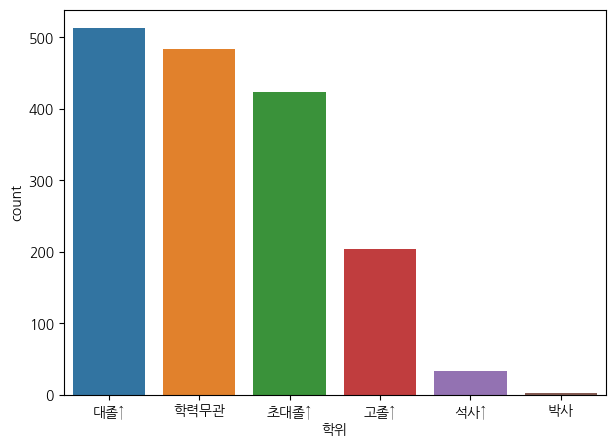

In [21]:
plt.figure(figsize=(7,5))
sns.countplot(data=saramin_df,x="학위",order=saramin_df["학위"].value_counts().index);
plt.savefig("../data/all_degree.png",transparent=True)

In [22]:
# 공고 내 학력별 요구 경력 갯수 테이블
sdf_deg_exp = saramin_df[["학위","경력","회사명"]].groupby(["학위","경력"]).count().unstack()
sdf_deg_exp.fillna(0)

회사명                                          
경력   경력 10년↑ 경력 1년↑ 경력 3년↑ 경력 5년↑  경력 무관    신입 신입 및 경력
학위                                                    
고졸↑      1.0   24.0   31.0   24.0   86.0  12.0    26.0
대졸↑     22.0   68.0  120.0   86.0  124.0  14.0    79.0
박사       0.0    0.0    0.0    0.0    2.0   0.0     0.0
석사↑      2.0    5.0    7.0    4.0    6.0   3.0     6.0
초대졸↑     8.0   54.0   69.0   33.0  174.0  17.0    69.0
학력무관     5.0   49.0   61.0   32.0  273.0   9.0    54.0

<AxesSubplot: xlabel='학위'>

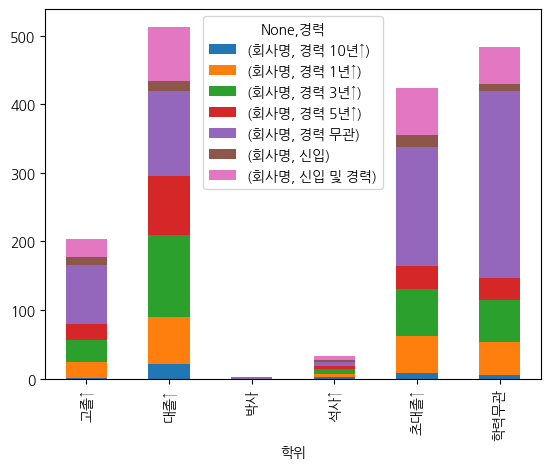

In [23]:
sdf_deg_exp.plot.bar(stacked=True)

##### 공고중 학력이 대졸이상인 공고중에서 요구하는 경력별 전체 공고 비율 시각화

In [24]:
sdf_bach = saramin_df.loc[saramin_df["학위"]=="대졸↑"]

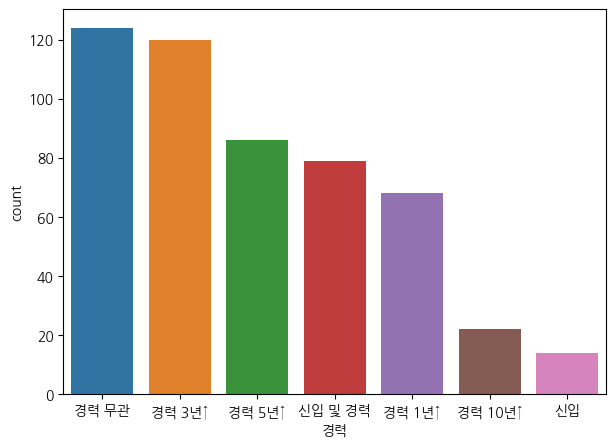

In [25]:
plt.figure(figsize=(7,5))
sns.countplot(data=sdf_bach,x=sdf_bach["경력"],order=sdf_bach["경력"].value_counts().index);
plt.savefig("../data/bachelor_exp2.png",transparent=True)

##### 공고 내 키워드(ROS, 자율주행, ML/DL등) 비율을 시각화

In [ ]:
print(len(df_auto), len(df_ctr), len(df_dsg), len(df_emb), len(df_ml), len(df_ros))

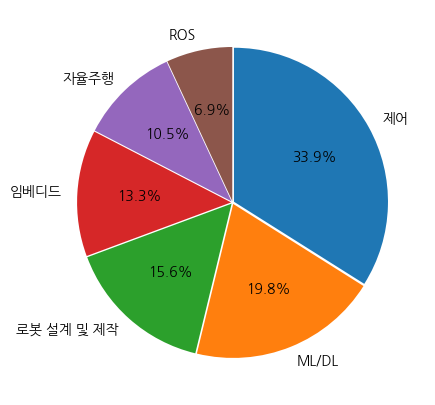

In [26]:
plt.figure(figsize=(7,5))
num = [681, 398, 312, 266, 210, 139]
labels = ["제어","ML/DL","로봇 설계 및 제작","임베디드","자율주행","ROS"]
plt.pie(num, labels=labels, autopct = '%.1f%%',startangle=90,explode=[0.01,0.01,0.01,0.01,0.01,0.01],counterclock = False);
plt.savefig("../data/all_tag_ratio_pie.png",transparent=True)

#### 지도 시각화
- 기업 정보에 담긴 상세 주소를 이용
- geopy를 이용해 상세 주소의 위.경도 좌표를 추출
- geopy 이용 전 기업 정보 내 주소를 수정

##### 기업 정보 내 주소 수정
- 예를 들어 주소가 경북 경주시 태종로 516, 산학협력관 2층 207호 이라면 
- 경북 경주시 태종로 516, 을 추출
- 그 후 ,를 제거

In [ ]:
saramin_df["수정된 주소"] = np.nan
saramin_df["수정된 주소"].replace(np.nan,"",inplace=True)
saramin_df["기업 정보"].replace(np.nan,"",inplace=True)

In [ ]:
for i in range(len(saramin_df)):
    saramin_df["수정된 주소"][i] = saramin_df["기업 정보"][i][saramin_df["기업 정보"][i].find("기업주소") + 5:len(saramin_df["기업 정보"][i])]

In [ ]:
def get_address(x):
    x1 = x.split(' ')
    return " ".join(x1[0:4])

In [ ]:
saramin_df["기업 주소"] = saramin_df["수정된 주소"].apply(get_address)

In [ ]:
saramin_df["기업 주소"] = saramin_df["기업 주소"].str.strip(',')

In [ ]:
geo_local = Nominatim(user_agent='South Korea')

#위도 반환 함수
def geocoding_lat(address):
    try:
        geo = geo_local.geocode(address)
        return geo.latitude

    except:
        return 0

#경도 반환 함수
def geocoding_lon(address):
    try:
        geo = geo_local.geocode(address)
        return geo.longitude

    except:
        return 0

In [ ]:
saramin_df['위도'] = saramin_df['기업 주소'].apply(geocoding_lat)

In [ ]:
saramin_df['경도'] = saramin_df['기업 주소'].apply(geocoding_lon)

In [27]:
my_map = folium.Map(location=[36,127],zoom_start=7, tiles="cartodbpositron")
for i in range(len(saramin_df)):
    folium.Marker(location=[saramin_df['위도'][i],saramin_df['경도'][i]],
                popup=saramin_df['URL'][i],
                icon=folium.Icon(icon="info-sign")).add_to(my_map)
my_map